In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE

from scipy.spatial.distance import cdist
sns.set_theme()

# Data filtering by reviews

In [2]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 # change to set one
# filter data with the minimum reviews
rev_filter = filter_df(avis_clean, min_reviews)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


# NNMF

In [489]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]
G

array([[0.14382481, 0.74444682, 0.54067499, ..., 0.10409893, 0.01784198,
        0.01026847],
       [1.15853361, 0.66935085, 0.70442709, ..., 0.38688394, 0.35072878,
        0.48537336],
       [0.55548329, 0.50590919, 0.54736474, ..., 0.41276769, 0.74742814,
        0.7906489 ],
       ...,
       [1.15378271, 0.75840296, 1.086939  , ..., 1.07757492, 0.46011419,
        0.59921417],
       [0.54360927, 0.94284411, 0.27739629, ..., 0.49414539, 0.32245009,
        0.58386953],
       [0.24266537, 0.68619341, 0.14901347, ..., 0.23433089, 0.74378474,
        0.94266405]])

In [373]:
#sns.heatmap(G[:100, :])

## User-tag one hot encoding matrix

In [412]:
# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
filter_games_index = pd.merge(rev_filter["Game id"].drop_duplicates(), games_table_assoc.reset_index(), on="Game id")
filter_users_index = pd.merge(rev_filter["User id"].drop_duplicates(), users_table_assoc.reset_index(), on="User id")

filter_games_index.columns = ["Game id", "Game index"]
filter_users_index.columns = ["User id", "User index"]

In [413]:
users_tags = filter_users_index.merge(avis_clean, on="User id").merge(jeux_clean, on="Game id")[["User id", "Type"]]
users_tags["Type"] = users_tags["Type"].str.split("|")
users_tags = users_tags.explode("Type")
users_tags["Type"] = users_tags["Type"].str.strip().str.lower()
users_tags = users_tags.drop_duplicates()

users_tags = users_tags.pivot_table(index="User id", columns="Type", aggfunc="size", fill_value = 0, dropna=False)
users_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,...,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
User id,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,1,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,0,1,...,1,0,0,1,1,0,0,1,1,1
3,1,1,0,1,1,1,1,1,0,1,...,1,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9583,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
9596,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1


## Game-tag one hot encoding matrix

In [414]:
games_filter = pd.merge(jeux_clean, filter_games_index, on="Game id")
games_exploded = games_filter.copy()
games_exploded["Type"] = games_filter[["Game id", "Type"]]["Type"].str.split('|')

games_exploded = games_exploded.explode("Type")
games_exploded["Type"] = games_exploded["Type"].str.strip().str.lower()
games_exploded = games_exploded.drop_duplicates()

games_tags = games_exploded.pivot_table(index="Game id", columns="Type", aggfunc='size', fill_value=0, dropna=False)
games_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,...,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
Game id,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Delete rare tags

In [415]:
tags_freq = pd.DataFrame(index=games_tags.columns)
tags_freq["Sum"] = games_tags.apply(sum, axis=0)
tags_freq = tags_freq.reset_index().sort_values(by="Sum", ascending=False)

# Delete unpopular tags
tags_filter = tags_freq[tags_freq["Sum"] >= 20]
tags_filter = tags_filter.dropna()
games_tags = games_tags.loc[:, tags_filter["Type"].values]
users_tags = users_tags.loc[:, tags_filter["Type"].values]
games_tags.shape, tags_filter.shape, users_tags.shape
games_tags

Type,jeux de plateau,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,majorité,...,draft,pirate,historique,jeu de logique,jeux de dés,pari,créativité,transport de marchandise,lettres / mots,zombies
Game id,,,,,,,,,,,,,,,,,,,,,
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10508,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [416]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# #sns.set_theme(rc={'figure.figsize':(6,4)})
# sns.histplot(tags_freq["Sum"], ax=ax1)

# tags_limit = tags_freq[tags_freq["Sum"] < 200]
# sns.histplot(tags_limit["Sum"], ax=ax2)

# plt.suptitle("Tags apperance distribution")
# ax1.set_xlabel("Number of tags")
# ax2.set_xlabel("Number of tags")

# ax1.set_ylabel("Number of games")
# ax2.set_ylabel("Number of games")

In [417]:
# plt.imshow(G[:100, :], aspect="auto")
# plt.grid(False)

## Games clustering (NNMF profiles based)

In [490]:
sns.set_theme(rc={"figure.figsize":(6, 4)})
distortions_means = []
centroids_distances = []
nb_clusters = np.arange(5, 60, 5)
for n in nb_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42) 
    kmeans.fit(G) 

    distances = cdist(G, kmeans.cluster_centers_, metric="euclidean")
    
    distances = pd.DataFrame({"Distance_centroid": np.take_along_axis(distances, kmeans.labels_[..., None], axis=1).flatten(),
                              "Cluster": kmeans.labels_})
    mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
    distortions_means.append(mean_distortion)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    centroids_distances.append(mean)
    #scores.append(kmeans.inertia_)

Text(0, 0.5, 'Mean distance')

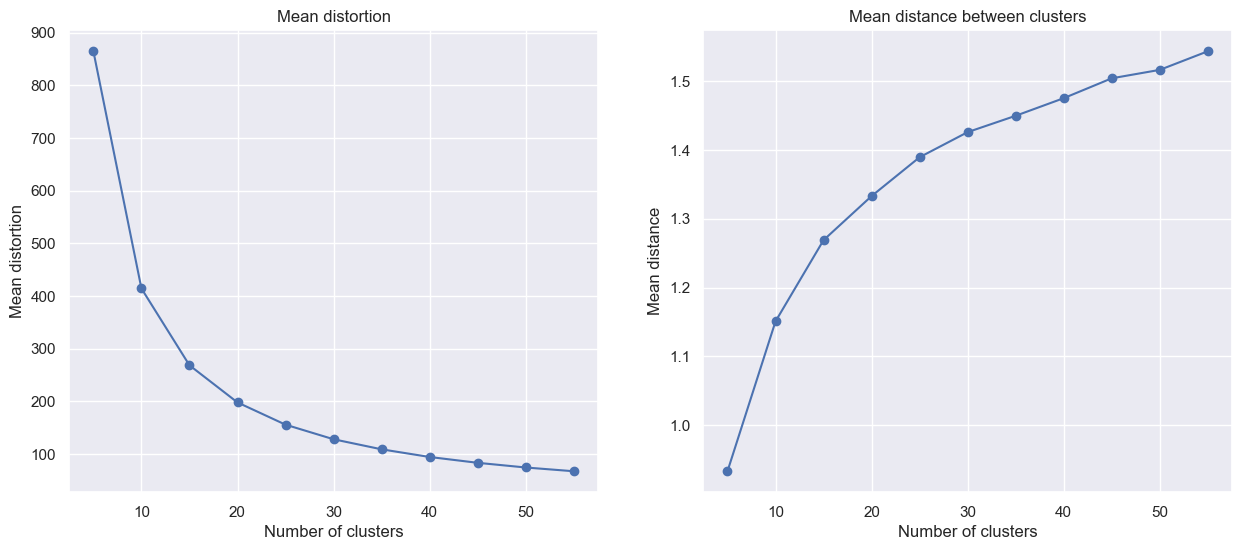

In [491]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(nb_clusters[:20], distortions_means[:20], marker='o')
ax1.set_title("Mean distortion")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Mean distortion")

ax2.plot(nb_clusters[:20], centroids_distances[:20], marker='o')
ax2.set_title("Mean distance between clusters")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Mean distance")

### KMeans clustering + stats

In [666]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 
game_labels = kmeans.labels_ 

# Distances from centroids (calc to all centroids, then select only necessary)
distances = np.power(cdist(G, kmeans.cluster_centers_, metric="euclidean"), 2)
games_clusters_dist = pd.DataFrame({"Game id":games_tags.index,
                        "Distance_centroid": np.take_along_axis(distances, kmeans.labels_[..., None], axis=1).flatten(),
                         "Cluster": kmeans.labels_})

# Intra-cluster distance
cluster_mean_dist = games_clusters_dist.groupby("Cluster")["Distance_centroid"].mean().reset_index()

# Ratings per cluster
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()
clusters_ratings = games_clusters_dist.merge(games_means[["Game id", "Rating"]], on="Game id")
means = clusters_ratings[["Cluster", "Rating"]].groupby(by="Cluster").agg(["mean", "std"])
means.columns = means.columns.to_flat_index()
means = means.reset_index()

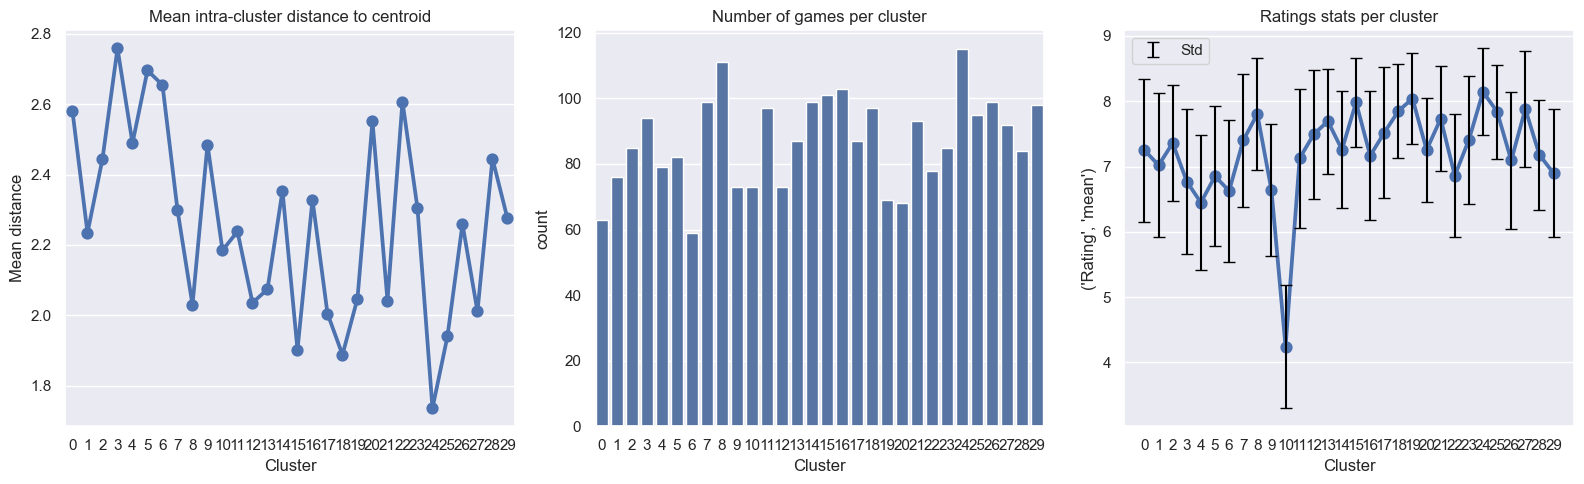

In [667]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Distance intra-cluster
sns.pointplot(data=cluster_mean_dist, x="Cluster", y="Distance_centroid", ax=ax1)
ax1.set_ylabel("Mean distance")
ax1.set_title("Mean intra-cluster distance to centroid")

# Games per cluster
sns.barplot(data=games_clusters_dist["Cluster"].value_counts(), ax=ax2)
ax2.set_title("Number of games per cluster")

# Ratings per cluster
sns.pointplot(data=means, x="Cluster", y=('Rating', 'mean'), ax=ax3)
plt.errorbar(means["Cluster"], means[('Rating', 'mean')], yerr=means[('Rating', 'std')], color="black", fmt='none', capsize=4, label="Std")
ax3.legend()
ax3.set_title("Ratings stats per cluster")

plt.tight_layout()

### Tags frequency per cluster

In [668]:
clusters_tags = games_clusters_dist.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T @ games_tags
clusters_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
# sns.heatmap(clusters_tags_normal)
#clusters_tags

In [669]:
clusters_tags_freq = clusters_tags_normal.stack().to_frame().reset_index()
clusters_tags_freq.columns = ["Cluster", "Type", "Frequency"]
sorted = clusters_tags_freq.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_4614/2047669260.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_freq.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))


In [670]:
COLUMN = "Frequency"
tag_per_clusters = clusters_tags_freq.groupby('Cluster').apply(lambda x: x.loc[x[COLUMN].nlargest(1).index, ["Cluster", "Type"]]).reset_index(drop=True)
games_clusters = pd.DataFrame(data={"Game id" : games_tags.index, "Cluster" : kmeans.labels_}).merge(tag_per_clusters, on="Cluster")

games_clusters["Type_cluster"] = games_clusters["Cluster"].astype(str) + " " + games_clusters["Type"]
games_clusters

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_4614/3142298841.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tag_per_clusters = clusters_tags_freq.groupby('Cluster').apply(lambda x: x.loc[x[COLUMN].nlargest(1).index, ["Cluster", "Type"]]).reset_index(drop=True)


,Game id,Cluster,Type,Type_cluster
0,6,12,asie,12 asie
1,15,1,parcours,1 parcours
2,25,21,horreur,21 horreur
3,28,24,transport de marchandise,24 transport de marchandise
4,34,24,transport de marchandise,24 transport de marchandise
...,...,...,...,...
2609,10507,14,lettres / mots,14 lettres / mots
2610,10508,8,parcours,8 parcours
2611,10514,24,transport de marchandise,24 transport de marchandise
2612,10531,15,placement d'ouvrier,15 placement d'ouvrier


In [674]:
G_embedded = TSNE(n_components=2, perplexity=50, max_iter=2000, random_state=1).fit_transform(G)

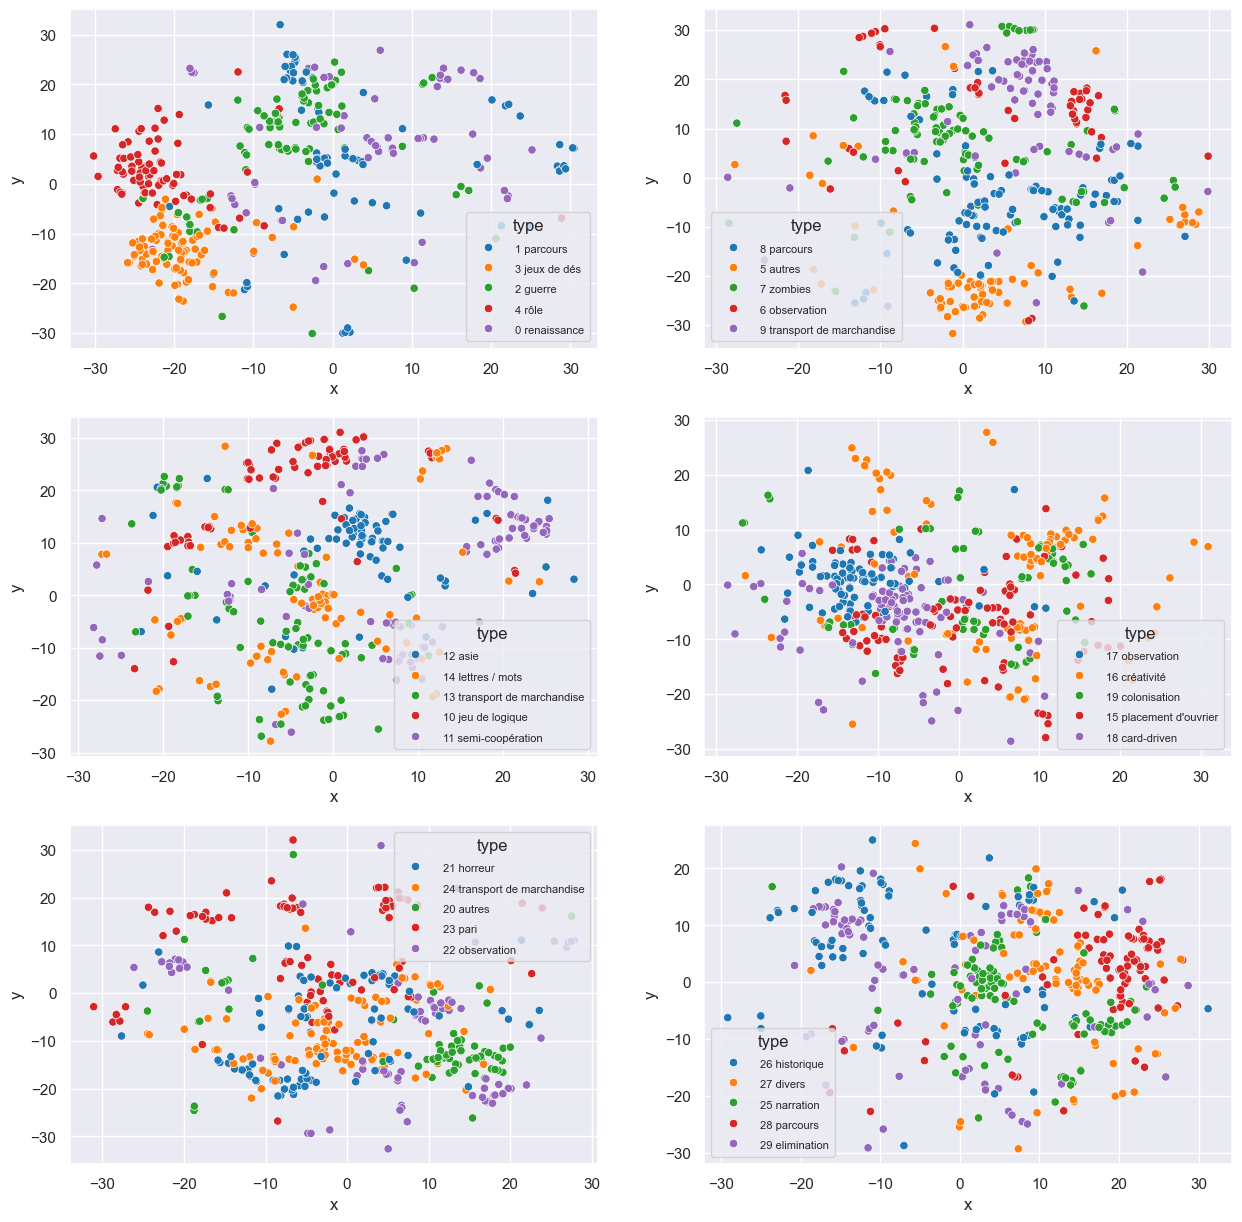

In [ ]:
import colorcet as cc
from itertools import product

palette = sns.color_palette(cc.glasbey_category10, n_colors=5)

NROWS, NCOLS = 3, 2
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 15))

indices = [np.arange(fst, fst + 5) for fst in range(0, NB_CLUSTERS, 5)]
indices = [[3, 4, 2, 20], [24, 17, 5, 9], [12, 11, 10, 15], [8, 18, 22]]
axes_ind = list(product(range(NROWS), range(NCOLS)))

for ax, ind_to_plot in enumerate(indices):
    indices = games_clusters[games_clusters["Cluster"].isin(ind_to_plot)].index
    data = pd.DataFrame(data={"x":G_embedded[indices, 0], "y":G_embedded[indices, 1],"type":games_clusters.loc[indices, "Type_cluster"]})
    ax = sns.scatterplot(data=data, x="x", y="y", hue="type", palette=palette, ax = axes[*axes_ind[ax]])

    plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text

### Probabilities of appearance of tags in each cluster

In [596]:
# probas_cluster = clusters_tags_freq.pivot_table(index="Type", columns="Cluster", values="Frequency")
# sns.set_theme(rc = {"figure.figsize":(13, 9)})
# ax = sns.heatmap(probas_cluster[:42])
# ax.set_title("Tags probabilities per cluster (1st half)")

In [597]:
# ax = sns.heatmap(probas_cluster[42:])
# ax.set_title("Tags probabilities per cluster (2nd half)")

****Very frequent tags per cluster***
- Cluster 17 -> theme **maritime** + **objectif secret** is highly present in this cluster 
- Cluster 12 : **pari**, **capture** 
- Cluster 18 : **pari**, **récolte**
- Cluster 3 -> +- horror theme (horreur, zombies, colonisation)

***Clusters 8, 9 : best rated clusters***
- Cluster 8 : mostly games in **historique & gestion** (médieval, les îles, politique, antiquité, rennaissance)
- Cluster 9 : hard to distinguish

- Cluster 19 : **lettres / mots** + **horreur, monstre**

***Cluster 16 is worst rated*** (every game is below the mean rating)
- Generic categories : jeux de dés, jeux de pions, lettres / mots

- Cluster 15, 5 is very dense (see TSNE) with low mean but some highly rated games are present.

In [70]:
# from itertools import product

# NROWS, NCOLS = 5, 4
# fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 11))
# for i, j in product(range(NROWS), range(NCOLS)):
#     cluster = i * NCOLS + j
#     #if cluster > 6:
#         #break
#     data = sorted[sorted["Cluster"] == cluster]
#     bars = sns.barplot(data, y="Type", x="Frequency", ax=axes[i, j])
#     bars.set_ylabel("")
#     bars.set_yticks(range(10))

#     mean_rating = means[means["Cluster"] == cluster][("Rating", "mean")].item()
#     bars.set_title(f"Cluster {cluster}, mean rating : {mean_rating:.4f}")

# plt.tight_layout()
# plt.subplots_adjust(top=0.93)
# plt.suptitle("Games clusters")

In [71]:
CD = games_clusters_dist.pivot_table(index="Game id", columns="Cluster", values="Distance_centroid", fill_value=0).T
CS = games_clusters_dist.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T
CS = CS / CS.sum(axis=0)
clusters_distances = (1 / (CD @ games_tags / CS.sum(axis=1).values[:, None] )).replace(np.inf, 0)
clusters_tags_dist = clusters_distances * clusters_tags / clusters_distances.sum(axis=1).values[:, None]

clusters_tags_dist_df = clusters_tags_dist.stack().to_frame().reset_index()
clusters_tags_dist_df.columns = ["Cluster", "Type", "Weight"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_dist_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_4614/1005291894.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_dist_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))


In [72]:
# fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 11))
# for i, j in product(range(NROWS), range(NCOLS)):
#     cluster = i * NCOLS + j
    
#     data = sorted[sorted["Cluster"] == cluster]
#     bars = sns.barplot(data, y="Type", x="Weight", ax=axes[i, j])
#     bars.set_ylabel("")
#     bars.set_yticks(range(10))

#     mean_rating = means[means["Cluster"] == cluster][("Rating", "mean")].item()
#     bars.set_title(f"Cluster : {cluster}, mean rating : {mean_rating:.4f}")

# plt.tight_layout()
# plt.subplots_adjust(top=0.93)
# plt.suptitle("Games clusters (1 / distance from centroid)")

In [73]:
# sns.set_theme(rc={"figure.figsize" : (6, 5)})
# ax = sns.heatmap(kmeans.cluster_centers_)

# ax.set_title("Centroids as latent factors")

### Tags clustering based on co occ matrix (normalized with jaccard index)

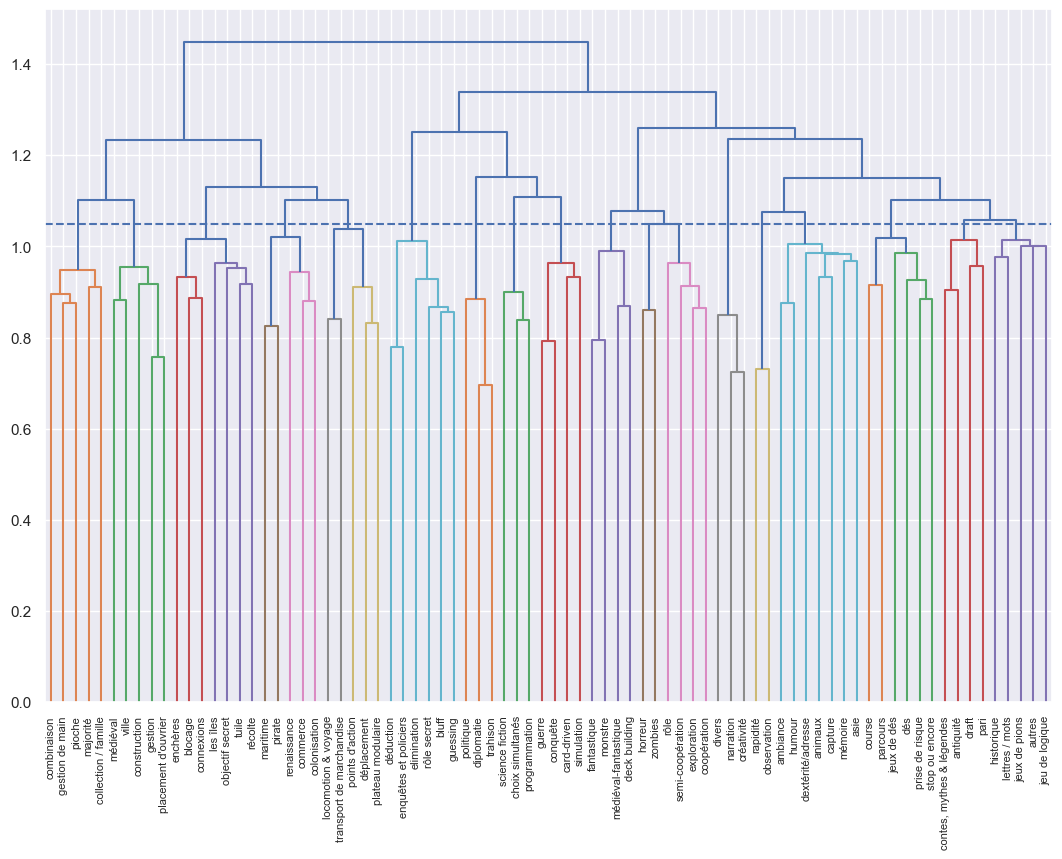

In [598]:
from scipy.spatial.distance import squareform

tags_select = tags_filter.tail(tags_filter.shape[0] - 5)["Type"].values

games_tags_select = games_tags.loc[:, tags_select]
games_to_delete = games_tags_select.sum(axis=1) != 0
games_tags_select = games_tags_select[games_to_delete]

cooc_matrix = games_tags_select.T @ games_tags_select
cooc_freq = cooc_matrix.apply(sum, axis=1)
cooc_matrix = cooc_matrix.sort_values(by=cooc_matrix.columns.tolist(), ascending=False)
games_tags_select.shape
cooc_matrix = cooc_matrix.loc[cooc_matrix.columns, :] # reordering for jaccard index normalization

# Cooc_matrix -> jaccard distance measure
total_occ = np.tile(games_tags_select.sum(axis=0).values, (games_tags_select.shape[1], 1))
cooc_matrix = 1 - cooc_matrix / (total_occ + total_occ.T - cooc_matrix)
np.fill_diagonal(cooc_matrix.values, val=0)

Z = linkage(squareform(cooc_matrix), method="ward", metric="jaccard") 

dendrogram(Z, leaf_rotation=90, leaf_font_size=8, labels=cooc_matrix.index)
plt.axhline(linestyle='--', y=1.05)
tags_coocc_clusters = pd.DataFrame(data={"Tag cluster" : fcluster(Z, 1.05, "distance"), "Type" : cooc_matrix.index})
#tags_coocc_clusters.sort_values("Tag cluster").tail(30)

# TSNE

## Games projection

In [599]:
# If game is in several categories at ones, keep only one
def keep_one_tag(row):
    ones = row[row == 1].index  # Find columns with "1"
    if len(ones) > 1:  # If more than one "1"
        keep = tags_freq[tags_freq["Type"].isin(ones)].head(1)["Type"] # keep rare one to boost it
        row[:] = 0  # Set all to 0
        row[keep] = 1  # Keep only the selected one
    return row

In [76]:
tags_freq

,Type,Sum
102,jeux de plateau,647
173,NaN,598
94,jeux de cartes,345
84,"hasard (dé, cartes, ...)",181
130,placement,167
...,...,...
165,vampire,1
166,vikings,1
65,enchères anglaises,1
168,volcan,1


In [77]:
# from reco_systems.user_game_matrix import get_matrix_user_game
# matrix_ratings, _, _, _ = get_matrix_user_game(rev_filter)
COLUMN = "Frequency"
tag_per_clusters = clusters_tags_freq.groupby('Cluster').apply(lambda x: x.loc[x[COLUMN].nlargest(1).index, ["Cluster", "Type"]]).reset_index(drop=True)
games_clusters = pd.DataFrame(data={"Game id" : games_tags.index, "Cluster" : kmeans.labels_}).merge(tag_per_clusters, on="Cluster")

games_clusters["Type_cluster"] = games_clusters["Cluster"].astype(str) + " " + games_clusters["Type"]
games_clusters

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_4614/3616912457.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tag_per_clusters = clusters_tags_freq.groupby('Cluster').apply(lambda x: x.loc[x[COLUMN].nlargest(1).index, ["Cluster", "Type"]]).reset_index(drop=True)


,Game id,Cluster,Type,Type_cluster
0,6,5,créativité,5 créativité
1,15,8,capture,8 capture
2,25,18,politique,18 politique
3,28,18,politique,18 politique
4,34,26,récolte,26 récolte
...,...,...,...,...
2609,10507,0,rôle secret,0 rôle secret
2610,10508,20,deck building,20 deck building
2611,10514,8,capture,8 capture
2612,10531,14,jeux de dés,14 jeux de dés


In [282]:
G_embedded = TSNE(n_components=2, perplexity=50, max_iter=2000, random_state=1).fit_transform(G)

In [79]:
# add labels to plot if necessary
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

### NNMF KMeans Clusters visualization

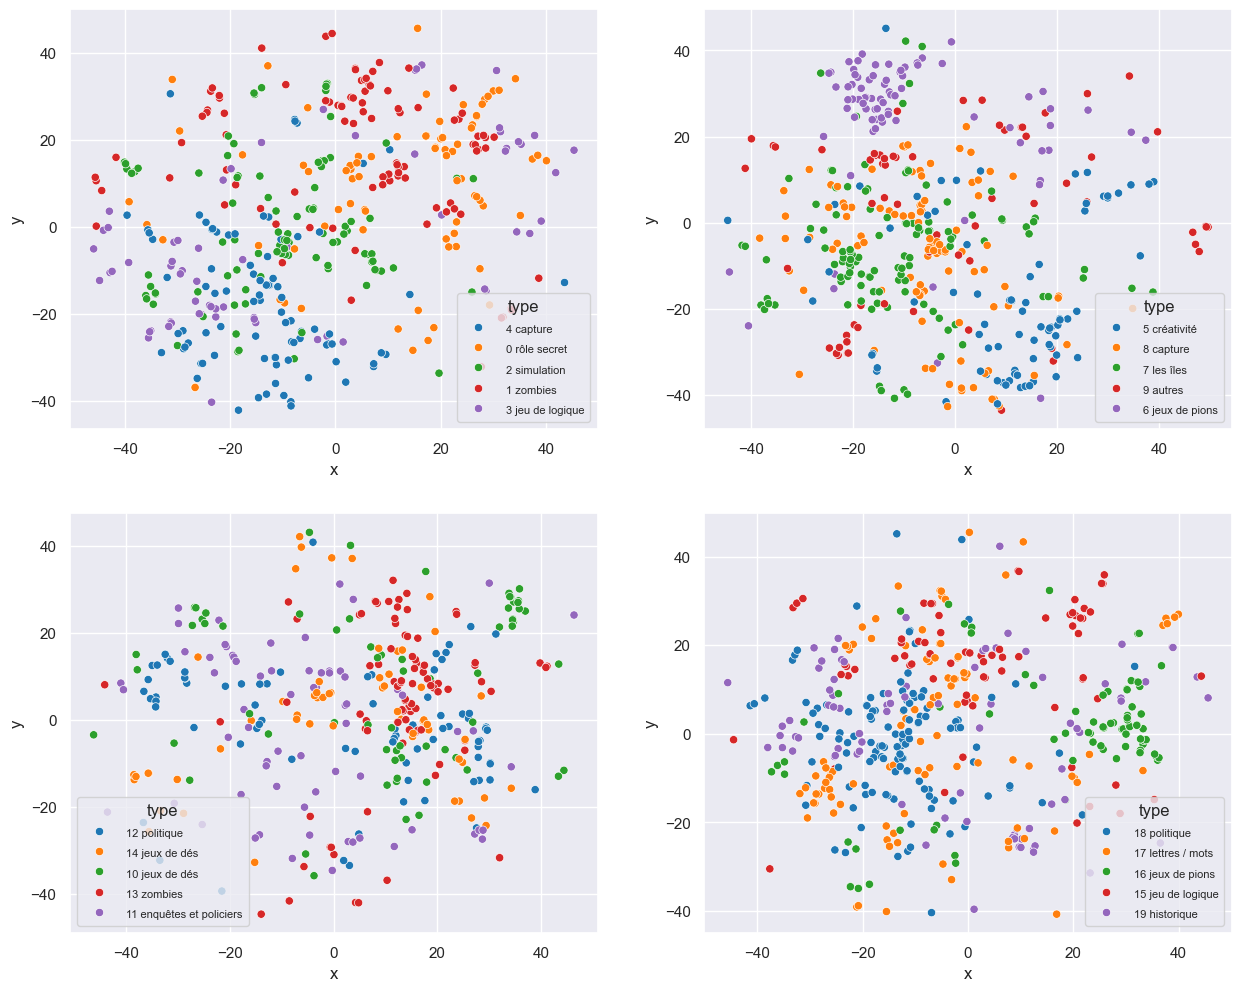

In [ ]:
import colorcet as cc
palette = sns.color_palette(cc.glasbey_category10, n_colors=5)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

indices = [np.arange(0, 5), np.arange(5, 10), np.arange(10, 15), np.arange(15, 20)]
axes_ind = [[0, 0], [0, 1], [1, 0], [1, 1]]

for ax, ind_to_plot in enumerate(indices):
    indices = games_clusters[games_clusters["Cluster"].isin(ind_to_plot)].index
    data = pd.DataFrame(data={"x":G_embedded[indices, 0], "y":G_embedded[indices, 1],"type":games_clusters.loc[indices, "Type_cluster"]})
    ax = sns.scatterplot(data=data, x="x", y="y", hue="type", palette=palette, ax = axes[*axes_ind[ax]])

    plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text

**Dense clusters**
- 5 : Frequent : autres, locomotion & voyage, guerre > 5%. Mean : 6.86, high std.

- 6 : Frequent : capture, sémi-coopération ~ 20%. Centroid : monstre. Mean : 7.5

- 8 : Best rated. Mean : 8.07 (high ratings, 3 games with rating ~6.5).

- 9 : 2nd best rated. Frequent : îles 20%, sémi-coopération, points d'actions, asie, trahison 15% (many other tags are highly present). Centroid : transport de marchandise, dextérité. Mean : 7.86. High rated games (1-2 games with 5-6 as rating).

- 13 : Frequent : narration, rôle, construction. Centroid : guessing, SF, draft. Mean : 7.10

- 16 : Worst rated. Mean : 4.60

### Co occurence matrix tags clusters visualization

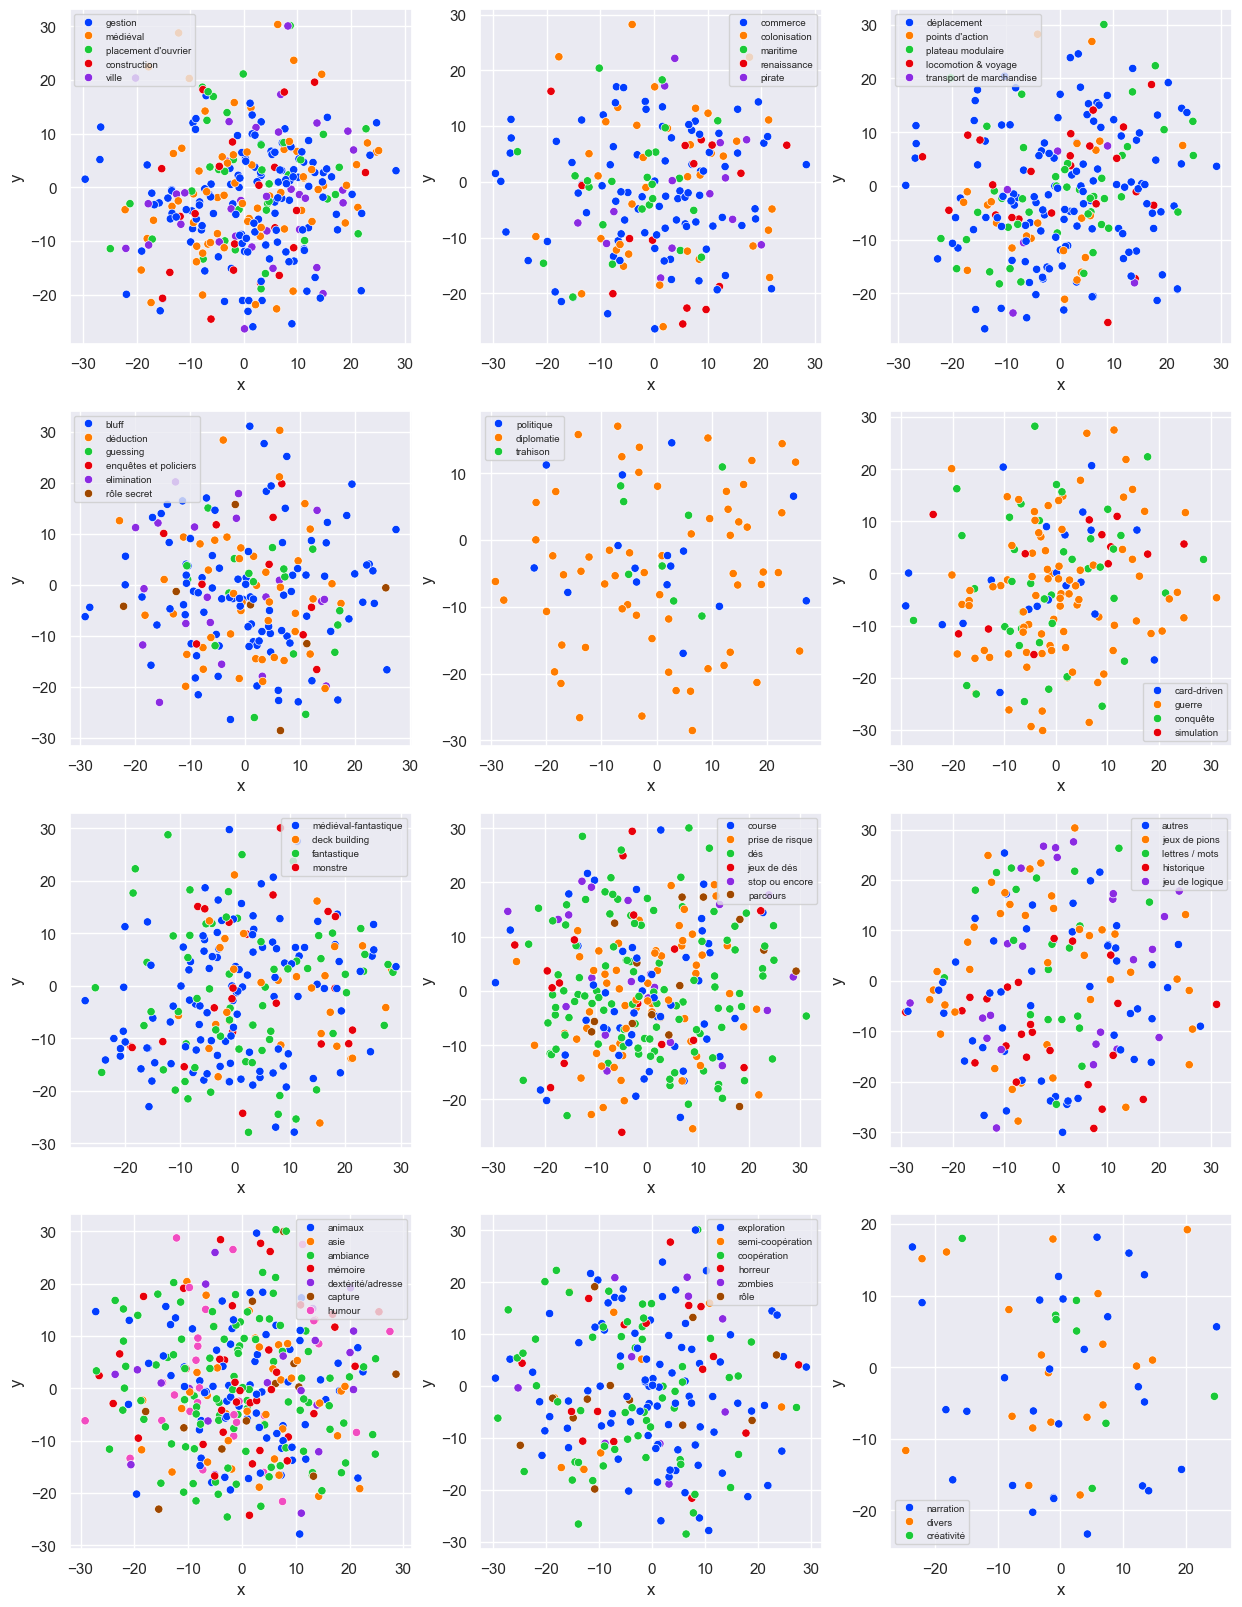

In [ ]:
from itertools import product
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

clusters_per_plot = [[2], [4], [5], [6], [7], [9], [10], [15], [17], [14], [11], [12]]
axes_plot = list(product(range(4), range(3)))

for ax, clusters in enumerate(clusters_per_plot):
    grouped_tags = tags_coocc_clusters[tags_coocc_clusters["Tag cluster"].isin(clusters)]["Type"]

    selected_games = games_tags[grouped_tags].apply(keep_one_tag, axis=1)
    labels = selected_games.apply(lambda row: (row == 1).idxmax() if (row == 1).sum() == 1 else np.nan, axis=1).reset_index().rename(columns={0 : "Type"})

    data = pd.DataFrame(data={"x":G_embedded[:, 0], "y":G_embedded[:, 1], "type":labels["Type"]})
    #print(grouped_tags)
    sns_ax = axes[*axes_plot[ax]] 
    sns.scatterplot(data=data, x="x", y="y", hue="type", palette="bright", ax=sns_ax)
    
    sns_ax.legend(*sns_ax.get_legend_handles_labels(), fontsize=7)

#plt.tight_layout()

## Co-occurence matrix

Text(0.5, 1.0, 'Cooc matrix (jaccard index)')

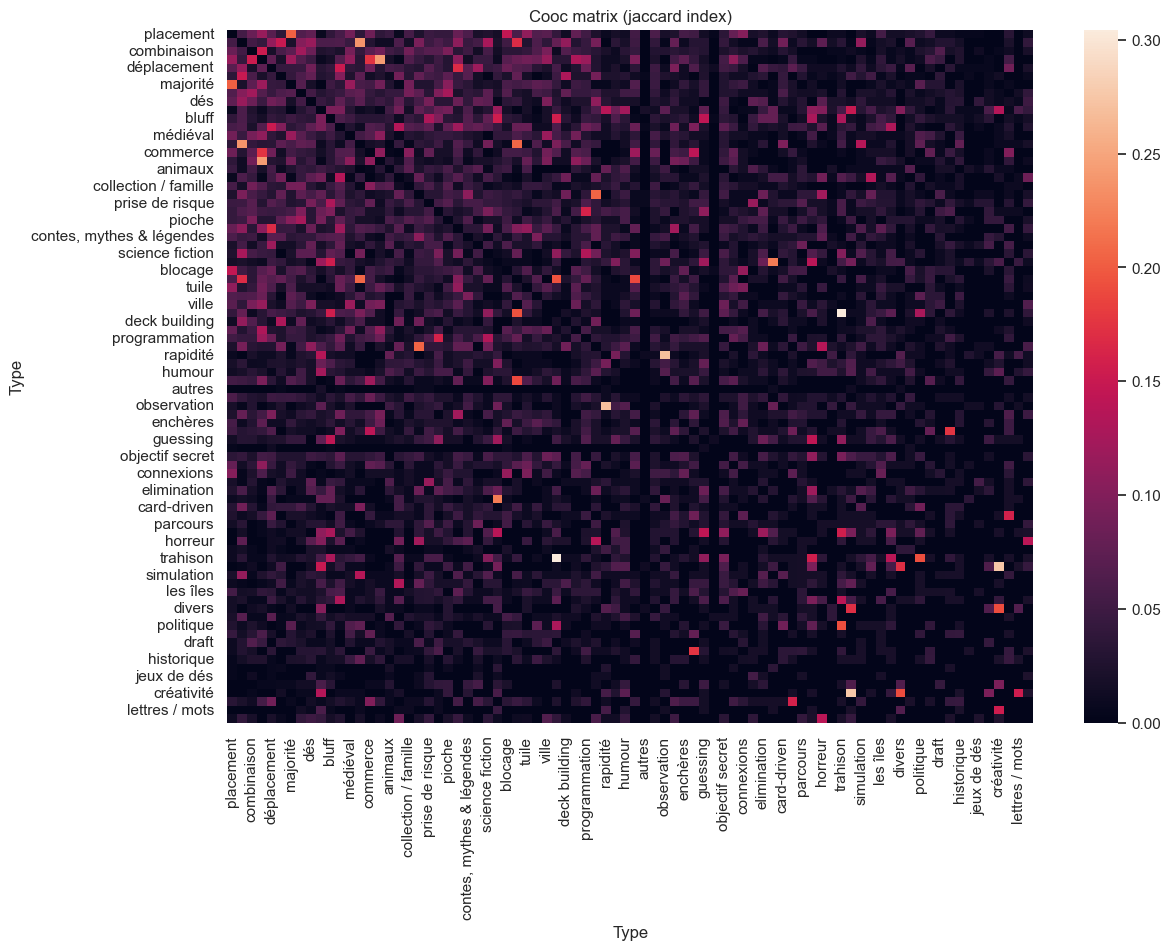

In [310]:
# !!! Important to reorder BEFORE projection
#games_tags = games_tags.loc[games_ids]

tags_select = tags_filter.tail(tags_filter.shape[0] - 3)["Type"].values
#tags_select = tags_filter["Type"].values
games_tags_select = games_tags.loc[:, tags_select]
games_to_delete = games_tags_select.sum(axis=1) != 0
games_tags_select = games_tags_select[games_to_delete]

cooc_matrix = games_tags_select.T @ games_tags_select
np.fill_diagonal(cooc_matrix.values, val=0)
cooc_freq = cooc_matrix.apply(sum, axis=1)
cooc_matrix = cooc_matrix.sort_values(by=cooc_matrix.columns.tolist(), ascending=False)
games_tags_select.shape
cooc_matrix = cooc_matrix.loc[cooc_matrix.columns, :] # reordering for jaccard index normalization

total_occ = np.tile(games_tags_select.sum(axis=0).values, (games_tags_select.shape[1], 1))
cooc_matrix = cooc_matrix / (total_occ + total_occ.T - cooc_matrix)
ax = sns.heatmap(cooc_matrix)
ax.set_title("Cooc matrix (jaccard index)")

/Users/bsh2022/Study/venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/bsh2022/Study/venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


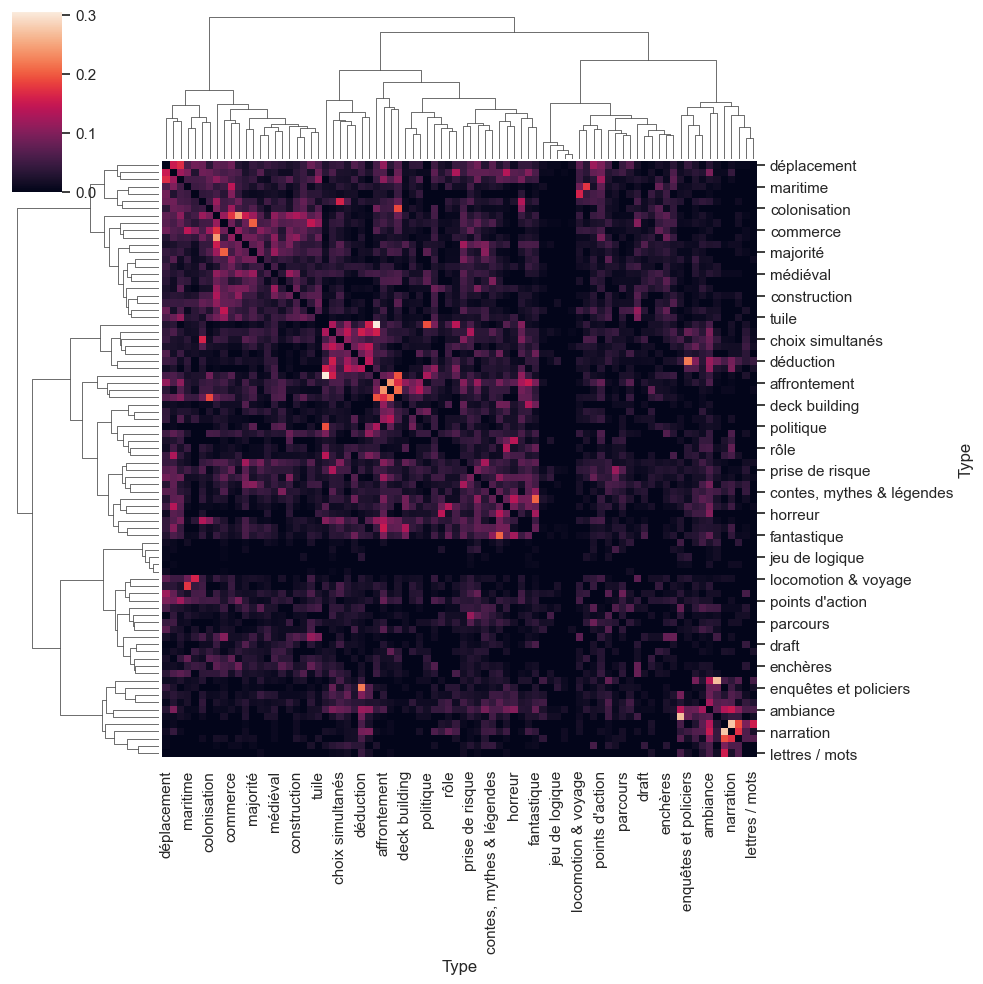

In [311]:
sns.set_theme(rc={"figure.figsize" : (15,9)})
ax = sns.clustermap(cooc_matrix, method="ward")

In [312]:
link_matrix_cooc = linkage(cooc_matrix, method="ward", metric="euclidean")
tags_cluster_labels = fcluster(link_matrix_cooc, 2, criterion="maxclust")
tags_cluster_labels

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_4960/58319813.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link_matrix_cooc = linkage(cooc_matrix, method="ward", metric="euclidean")


array([1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2], dtype=int32)

<Axes: xlabel='Type', ylabel='Type'>

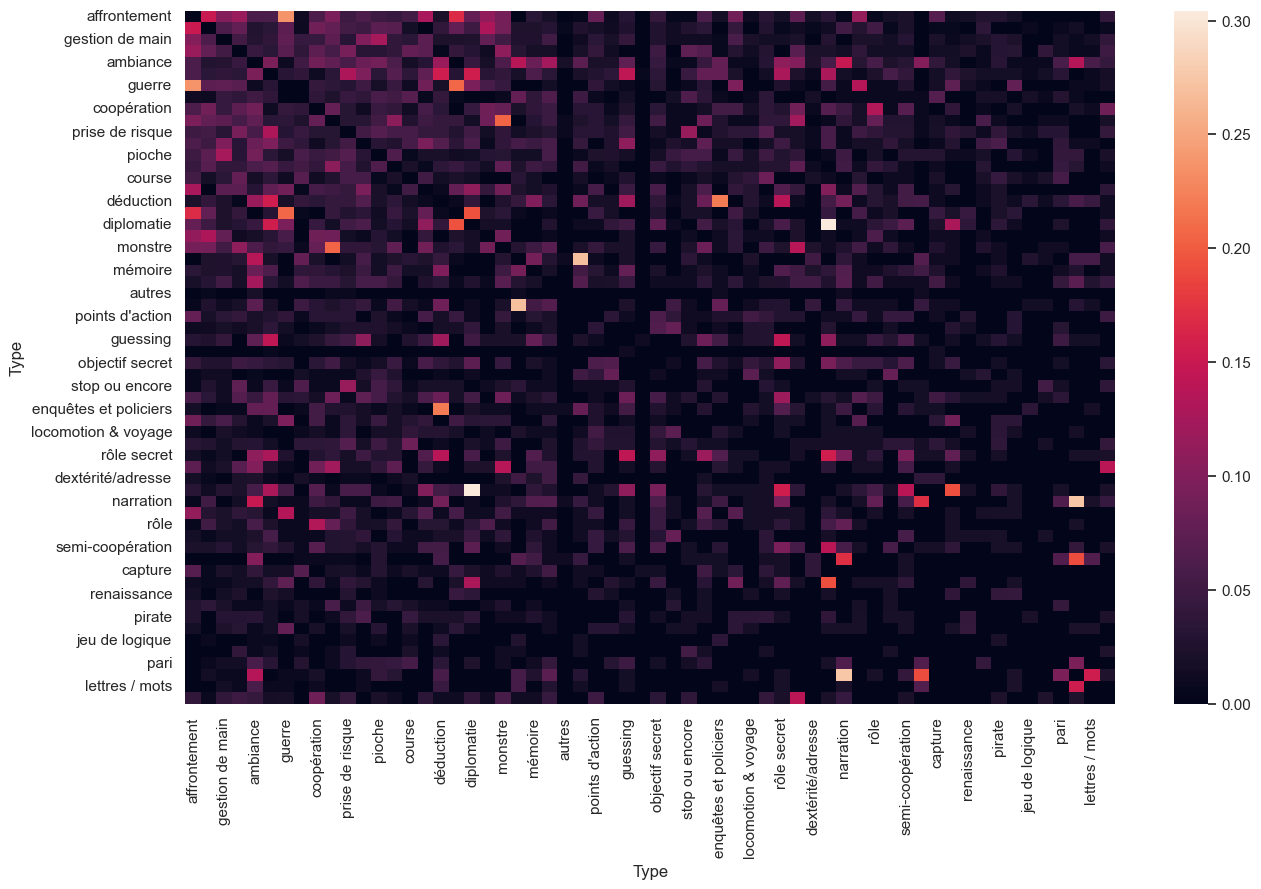

In [313]:
labels = cooc_matrix.index[tags_cluster_labels == 2]
reduced = cooc_matrix.loc[labels, labels]
sns.heatmap(reduced)

<Axes: xlabel='Type', ylabel='Type'>

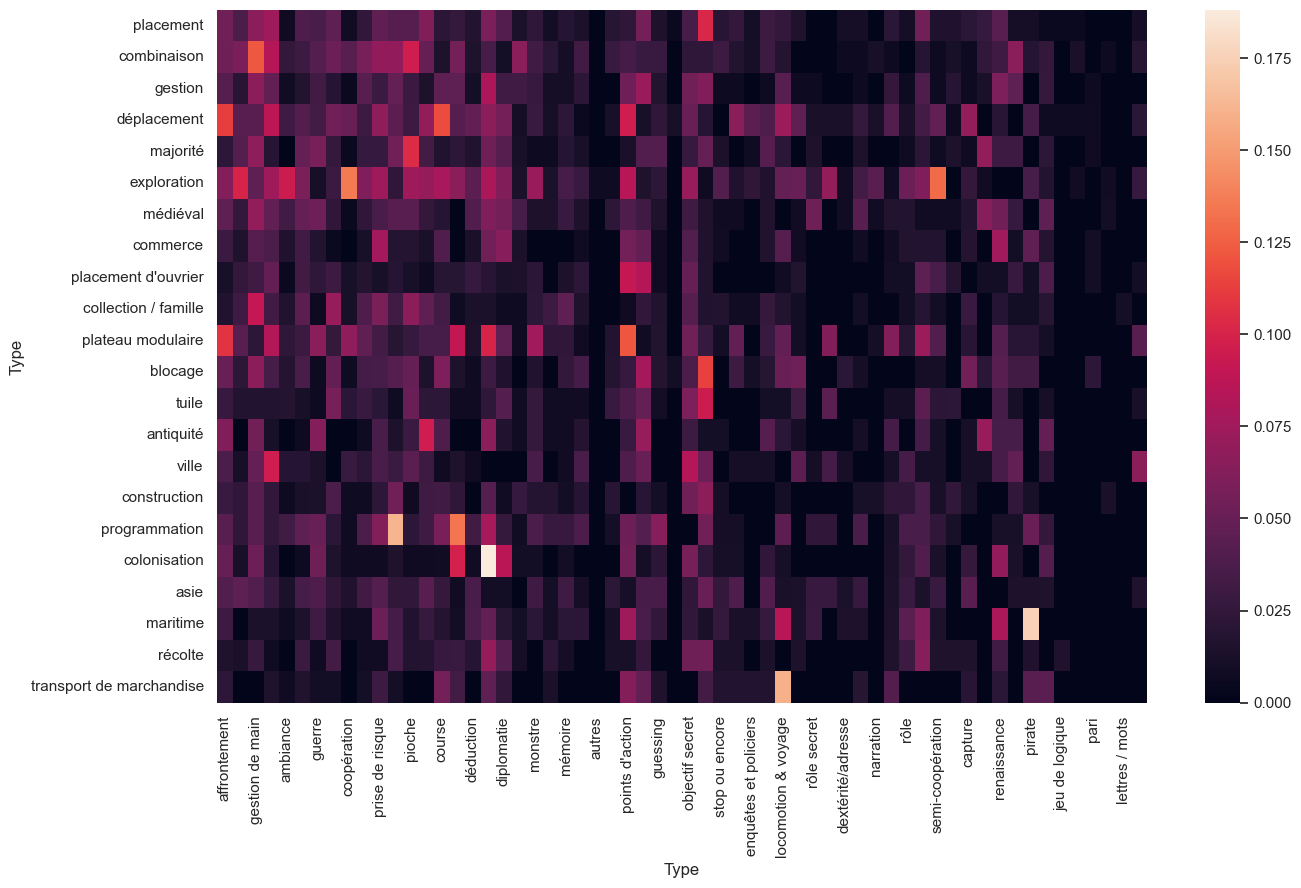

In [314]:
reduced = cooc_matrix.loc[cooc_matrix.index[tags_cluster_labels == 1], cooc_matrix.index[tags_cluster_labels == 2]]
sns.heatmap(reduced, annot=False)

### Tags projection in latent factors space

In [648]:
# games_count_encode = games_tags / games_tags.sum(axis=0)
# # Reordering before projection should be done (see 1st bloc of co occ matrix code)
# games_proj = games_count_encode.T @ G

# sns.set_theme(rc={'figure.figsize':(15,9)})
# ax = sns.heatmap(games_proj, cmap="viridis")
# ax.set_title("Tags on latent space")

In [649]:
# COMPONENT = 14
# sns.heatmap(games_proj.loc[:, [COMPONENT]].sort_values(by=COMPONENT).tail(30), cmap="viridis", cbar=True)
# plt.tight_layout()